## Product Reccomender Model

### Data Modelling

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import operator

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, cophenet, fcluster
from sklearn.metrics.pairwise import cosine_similarity
from sklearn_extra.cluster import KMedoids

In [2]:
# Set chart style
plt.style.use('fivethirtyeight')

In [3]:
# Set float display options
pd.set_option('display.float_format','{:,.2f}'.format)

In [4]:
# Import data
sales = pd.read_csv('../data/processed_sales.csv', 
                         dtype={'invoiceno': 'object', 
                                 'stockcode_caps': 'object', 
                                 'quantity': np.int32, 
                                 'unitprice': np.float32, 
                                 'customerid': 'object'
                                })

In [5]:
# import data
customer_location = pd.read_csv('../data/processed_customer.csv')
stock_descriptions= pd.read_csv('../data/processed_stock_descriptions.csv')
invoice = pd.read_csv('../data/cleaned_invoice.csv')

In [6]:
# Check column types and null values
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279513 entries, 0 to 279512
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   invoiceno       279513 non-null  object 
 1   stockcode_caps  279513 non-null  object 
 2   quantity        279513 non-null  int32  
 3   unitprice       279513 non-null  float32
 4   customerid      279513 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 8.5+ MB


In [7]:
# Check column types and null values
customer_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customerid       5772 non-null   object 
 1   domestic         5772 non-null   bool   
 2   recency_score    5611 non-null   float64
 3   frequency_score  5611 non-null   float64
 4   monetary_score   5611 non-null   float64
 5   cust_matrix      5611 non-null   object 
dtypes: bool(1), float64(3), object(2)
memory usage: 231.2+ KB


In [8]:
# Check column types and null values
stock_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   stockcode_caps     3817 non-null   object
 1   description_new    3817 non-null   object
 2   prodsales_deciles  3817 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 89.6+ KB


In [9]:
# Check column types and null values
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23195 entries, 0 to 23194
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   invoiceno    23195 non-null  object
 1   invoicedate  23195 non-null  object
dtypes: object(2)
memory usage: 362.5+ KB


In [10]:
# convert time to datetime
invoice['invoicedate'] = pd.to_datetime(invoice['invoicedate'])

In [11]:
# Merge datasets together
sales_data = sales.merge(customer_location, on='customerid', how='left') \
            .merge(invoice, on='invoiceno',how='left')

In [12]:
# Merge datasets together
sales_data = sales_data.merge(stock_descriptions[['stockcode_caps','prodsales_deciles']],
                              on='stockcode_caps',
                              how='left')

In [13]:
# Calculate revenue from unit price and quantity
sales_data['revenue'] = sales_data['unitprice'] * sales_data['quantity'] 

In [14]:
# create date features
sales_data['yearmonth'] = sales_data['invoicedate'].dt.to_period('M')

In [15]:
# create date features
sales_data['quarter'] = sales_data['invoicedate'].dt.to_period('Q')

In [16]:
# create date features
sales_data['week'] = sales_data['invoicedate'].dt.to_period('W')

### Feature engineering

Exponential decay function, assume effect of relevance decays uniformly over time. 

In [17]:
# check last invoice date in dataset
last_invoice_date = sales_data['invoicedate'].max()

In [18]:
# calculate invoice age
sales_data['invoice_age'] = pd.to_timedelta(last_invoice_date
                                            - sales_data['invoicedate']) / np.timedelta64(1, "D")

In [21]:
# calculate decay factor
sales_data['decay_1M'] = np.exp(np.log(0.5) / 30 * sales_data['invoice_age'])

In [24]:
# calculated revenue adjusted for decay 
sales_data['revenue_decay_1M'] = sales_data['revenue'] * sales_data['decay_1M']

### Train Test split

In [26]:
# Invoice date combinations
sales_by_invoice = sales_data.groupby(['customerid','invoiceno','invoicedate','yearmonth']) \
                                    .agg(total_revenue=('revenue',np.sum)) \
                                    .reset_index()

In [28]:
# Select only positive invoices
sales_by_invoice_excl_return = sales_by_invoice[sales_by_invoice['total_revenue']>0]

In [29]:
# select latest sales invoice of each customer
latest_sales_invoices = sales_by_invoice_excl_return.loc[sales_by_invoice_excl_return
                                                     .groupby('customerid').invoicedate.idxmax()]

In [30]:
# Check latest transaction datetime for the last invoice for each customer
latest_sales_invoices['invoicedate'].max()

Timestamp('2011-12-09 12:50:00')

In [31]:
# Check earliest transaction datetime for the last invoice for each customer
latest_sales_invoices['invoicedate'].min()

Timestamp('2011-10-17 13:19:00')

In [32]:
# Check transaction datetime for the last invoice for each customer by month
latest_sales_invoices.groupby('yearmonth').sum()

total_revenue
yearmonth               
2011-10       121,575.09
2011-11       659,432.83
2011-12       307,494.60

In [33]:
# Create column to indicate test data and prepopulate with 'False'
sales_data["test"] = False

In [34]:
# Select all products in the latest sales invoice of each customer and assign True
sales_data.loc[sales_data['invoiceno'].isin(latest_sales_invoices['invoiceno']), "test"] = True

In [35]:
# split test data
test_data = sales_data[sales_data['test']==True].copy()

In [36]:
# assign sales_data as test_data
train_data = sales_data

In [37]:
# check descriptive stats of count of stockcodes
test_data.groupby('invoiceno').agg(countproducts=('stockcode_caps',np.size)).describe()

countproducts
count       1,856.00
mean           31.79
std            65.99
min             1.00
25%             7.00
50%            15.00
75%            29.00
max           787.00

In [38]:
# create summary table of test invoices
test_invoices = sales_data[sales_data['test'] == True].groupby(['invoiceno',
                                                                'customerid',
                                                               'invoicedate',]) \
                                                    .agg(num_products=('stockcode_caps',np.size),
                                                   ).reset_index()

In [39]:
# calculate age of test invoices
test_invoices['invoice_age'] = pd.to_timedelta(last_invoice_date
                                            - test_invoices['invoicedate']) / np.timedelta64(1, "D")

In [2]:
# create concatnation of customerid and stockcode caps
test_data['cust_stock'] = test_data['customerid'] + '/' + test_data['stockcode_caps']

NameError: name 'test_data' is not defined

### Recommender Models

#### Basic ranking system based on Total Revenue

In [41]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    test_numproducts = test_invoices.loc[test_invoices['invoiceno'] == i,'num_products'].item()
    

    # select all sales before test invoice date
    past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                       ['stockcode_caps','revenue']] \
                        .groupby(['stockcode_caps']) \
                        .sum().reset_index()
    past_all_invoices['customerid'] = test_customerid
    past_all_purchases = past_all_invoices[past_all_invoices['revenue']>0]
    predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue']] \
                        .sort_values(by='revenue',ascending=False) \
                        .head(10).values.tolist())   
    predict_data.extend(predict_invoice)

In [42]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'top10'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [43]:
# create dataframe to store all predictions
predict_all = predict_data[['customerid','stockcode_caps','model','hit_rate','predicted_revenue']]

Basic ranking system based on decay adjusted Total Revenue

In [184]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    test_numproducts = test_invoices.loc[test_invoices['invoiceno'] == i,'num_products'].item()
    

    # select all sales before test invoice date
    past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                       ['stockcode_caps','revenue_decay_1M']] \
                        .groupby(['stockcode_caps']) \
                        .sum().reset_index()
    past_all_invoices['customerid'] = test_customerid
    past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
    predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                        .sort_values(by='revenue_decay_1M',ascending=False) \
                        .head(10).values.tolist())   
    predict_data.extend(predict_invoice)

In [188]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'top10_1m'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [189]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

#### Personalized ranking system

In [47]:
def personalized_ranking(revenue='revenue',num_predict=10, model_name='ranking'):
    '''returns top historical sales per customer'''
    # for each invoice: 
    predict_data = []
    for i in test_invoices['invoiceno'].values:
        predict_invoice = []
        past_products = []
        test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
        test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()

        # sums all previous invoices of each customerid
        past_cust_invoices = train_data.loc[(train_data['customerid']==test_customerid) & 
                                            (train_data['invoicedate']<test_invoicedate),
                           ['customerid','stockcode_caps',revenue]] \
                            .groupby(['customerid','stockcode_caps']) \
                            .sum().reset_index()

        # compare number of products in test invoice 
        # vs unique products with positive sales in all past invoices
        past_cust_purchases = past_cust_invoices[past_cust_invoices[revenue]>0]
        past_products.extend(past_cust_purchases['stockcode_caps'])

        if past_cust_purchases.shape[0] > 0:
        # if there were past purchases for this customer         
            invoice_count_difference = past_cust_purchases.shape[0] - num_predict       
            if invoice_count_difference >= 0:                                                 
            # and if the past purchases had more products than the test invoice
            # select the top n products where n = product length of test invoice
                predict_data.extend(past_cust_purchases.head(num_predict).values.tolist())

            else:
            # else, being that the past puchases were fewer than test invoice,
            # add the products from past purchases, 
                predict_data.extend(past_cust_purchases.values.tolist())
            # and add additional products from all past invoices
            # to make up for the shortfall in products
                past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                                   ['stockcode_caps',revenue]] \
                                    .groupby(['stockcode_caps']) \
                                    .sum().reset_index()
                past_all_invoices['customerid'] = test_customerid
                past_all_purchases = past_all_invoices[past_all_invoices[revenue]>0]      
                # select products that are not in past_products list
                past_all_purchases_select = past_all_purchases[~past_all_purchases
                                                ['stockcode_caps'].isin(past_products)]
                predict_invoice.extend(past_all_purchases_select[['customerid',
                                                                  'stockcode_caps',
                                                                  revenue]] \
                                    .sort_values(by=revenue,ascending=False) \
                                    .head(-invoice_count_difference).values.tolist())   
        else:
        # else, being that there were no past purchases 
        # select all sales before test invoice date
            past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                               ['stockcode_caps',revenue]] \
                                .groupby(['stockcode_caps']) \
                                .sum().reset_index()
            past_all_invoices['customerid'] = test_customerid
            past_all_purchases = past_all_invoices[past_all_invoices[revenue]>0]
            predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps',revenue]] \
                                .sort_values(by=revenue,ascending=False) \
                                .head(num_predict).values.tolist())   
        
        predict_data.extend(predict_invoice)
    
    # compile prediction results
    predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
    predict_data['model'] = model_name
    predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
    predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
    predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                                .merge(test_data[['cust_stock','revenue']],
                                                           on='cust_stock',
                                                           how='left',
                                                          ).fillna(0)['revenue']

    return predict_data

In [48]:
# run personalized ranking function
predict_data = personalized_ranking(revenue='revenue',num_predict=10,model_name='ranking')

In [49]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'ranking'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [50]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [51]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

hit_rate  predicted_revenue
model                                
ranking       0.14         128,063.58
top10         0.09         102,709.34
top10_1m      0.11         120,728.90

Personalized ranking model with revenue decay

In [52]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    
    # sums all previous invoices of each customerid
    past_cust_invoices = train_data.loc[(train_data['customerid']==test_customerid) & 
                                        (train_data['invoicedate']<test_invoicedate),
                       ['customerid','stockcode_caps','revenue_decay_1M']] \
                        .groupby(['customerid','stockcode_caps']) \
                        .sum().reset_index()
                                         
    # compare number of products in test invoice 
    # vs unique products with positive sales in all past invoices
    past_cust_purchases = past_cust_invoices[past_cust_invoices['revenue_decay_1M']>0]
    past_products.extend(past_cust_purchases['stockcode_caps'])
    
    if past_cust_purchases.shape[0] > 0:
    # if there were past purchases for this customer         
        invoice_count_difference = past_cust_purchases.shape[0] - 10       
        if invoice_count_difference >= 0:                                                 
        # and if the past purchases had more products than the test invoice
        # select the top n products where n = product length of test invoice
            predict_data.extend(past_cust_purchases.head(10).values.tolist())
        
        else:
        # else, being that the past puchases were fewer than test invoice,
        # add the products from past purchases, 
            predict_data.extend(past_cust_purchases.values.tolist())
        # and add additional products from all past invoices
        # to make up for the shortfall in products
            past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                               ['stockcode_caps','revenue_decay_1M']] \
                                .groupby(['stockcode_caps']) \
                                .sum().reset_index()
            past_all_invoices['customerid'] = test_customerid
            past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]      
            past_all_purchases_select = past_all_purchases[~past_all_purchases['stockcode_caps'].isin(
                past_products)]
            predict_invoice.extend(past_all_purchases_select[['customerid',
                                                              'stockcode_caps',
                                                              'revenue_decay_1M']] \
                                .sort_values(by='revenue_decay_1M',ascending=False) \
                                .head(-invoice_count_difference).values.tolist())   
    else:
    # else, being that there were no past purchases 
    # select all sales before test invoice date
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                           ['stockcode_caps','revenue_decay_1M']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .sort_values(by='revenue_decay_1M',ascending=False) \
                            .head(10).values.tolist())   
    predict_data.extend(predict_invoice)

In [53]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'ranking1m'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [54]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [55]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

hit_rate  predicted_revenue
model                                 
ranking        0.14         128,063.58
ranking1m      0.15         142,207.14
top10          0.09         102,709.34
top10_1m       0.11         120,728.90

#### Adaptive nearest neighbour

In [56]:
# select all customers with prior sales
cust_with_prior_sales = test_invoices[test_invoices['customerid'].isin(
                            # test_invoice customerids which are in
                            sales_data.loc[(sales_data['revenue']>0) &
                                # sales_data excluding the invoices that are in test_invoices
                                ~(sales_data['invoiceno'].isin(
                                    test_invoices['invoiceno'])),'customerid'])]

In [398]:
train_data

invoiceno stockcode_caps  quantity  unitprice customerid  domestic  \
0         537626          21064         6       5.95      12347     False   
1         537626          21731        12       1.65      12347     False   
2         537626          22195        12       1.65      12347     False   
3         537626          22212         6       2.10      12347     False   
4         537626          22375         4       4.25      12347     False   
...          ...            ...       ...        ...        ...       ...   
279508    581498         85049E         4       3.29     581498      True   
279509    581498         85099B         5       4.13     581498      True   
279510    581498         85099C         4       4.13     581498      True   
279511    581498          85150         1       4.96     581498      True   
279512    581498          85174         1      10.79     581498      True   

        recency_score  frequency_score  monetary_score cust_matrix  ...  \
0                3.00             3.00            3.00   star_cust  ...   
1                3.00             3.00            3.00   star_cust  ...   
2                3.00             3.00            3.00   star_cust  ...   
3                3.00             3.00            3.00   star_cust  ...   
4                3.00             3.00            3.00   star_cust  ...   
...               ...              ...             ...         ...  ...   
279508           3.00             2.00            3.00    new_cust  ...   
279509           3.00             2.00            3.00    new_cust  ...   
279510           3.00             2.00            3.00    new_cust  ...   
279511           3.00             2.00            3.00    new_cust  ...   
279512           3.00             2.00            3.00    new_cust  ...   

       invoice_age  decay_3M  decay_2M decay_1M revenue_decay_3M  \
0           366.91      0.06      0.01     0.00             2.12   
1           366.91      0.06      0.01     0.00             1.17   
2           366.91      0.06      0.01     0.00             1.17   
3           366.91      0.06      0.01     0.00             0.75   
4           366.91      0.06      0.01     0.00             1.01   
...            ...       ...       ...      ...              ...   
279508        0.10      1.00      1.00     1.00            13.15   
279509        0.10      1.00      1.00     1.00            20.63   
279510        0.10      1.00      1.00     1.00            16.51   
279511        0.10      1.00      1.00     1.00             4.96   
279512        0.10      1.00      1.00     1.00            10.78   

       revenue_decay_2M  revenue_decay_1M   test  age  svc_kmedoids_cluster  
0                  0.52              0.01  False -367                  0.00  
1                  0.29              0.00  False -367                  0.00  
2                  0.29              0.00  False -367                  0.00  
3                  0.18              0.00  False -367                  0.00  
4                  0.25              0.00  False -367                  0.00  
...                 ...               ...    ...  ...                   ...  
279508            13.14             13.13   True   -1                   NaN  
279509            20.63             20.60   True   -1                   NaN  
279510            16.50             16.48   True   -1                   NaN  
279511             4.95              4.95   True   -1                   NaN  
279512            10.78             10.77   True   -1                   NaN  

[279513 rows x 26 columns]

In [400]:
# select date prior to test invoice date for all customers
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    
    if test_customerid in cust_with_prior_sales['customerid'].values:
        # sums all previous invoices of each customerid
        past_invoices = sales_data[sales_data['invoicedate']<test_invoicedate]

        # create cross tabulation by customerid as index and stockcodes as columns 
        # with sum of revenue as value
        past_invoices_cross = pd.crosstab(index=past_invoices['customerid'],
                                            columns=past_invoices['stockcode_caps'],
                                            values=past_invoices['revenue'], 
                                            aggfunc=sum,
                                            normalize='index',
                                           )

        # calculate cosine similarity between test customer and all other customers
        cust_similarity = cosine_similarity(past_invoices_cross.loc[[test_customerid]],
                          past_invoices_cross.drop(test_customerid))

        # select customer that is the nearest neighbour based on cosine similarity 
        nearest_neighbor = pd.DataFrame(cust_similarity.T , 
                                index=past_invoices_cross.drop(test_customerid).index,
                                columns=['similarity']
                               )['similarity'].idxmax()

        # get past sales nearest neighbour adjusted with revenue decay
        past_all_invoices = sales_data.loc[(sales_data['customerid'] == nearest_neighbor) &
                                                   (sales_data['invoicedate'] < test_invoicedate), 
                                                   ['stockcode_caps','revenue_decay_1M']
                                                  ].groupby(['stockcode_caps']).sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .sort_values(by='revenue_decay_1M',ascending=False) \
                            .head(10).values.tolist())          
            
        predict_data.extend(predict_invoice)

    else:
    # else, being that there were no past purchases 
    # select all sales before test invoice date
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                           ['stockcode_caps','revenue_decay_1M']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .sort_values(by='revenue_decay_1M',ascending=False) \
                            .head(10).values.tolist())   
   
        predict_data.extend(predict_invoice)
        



In [401]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'nearestneighbour'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [403]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [404]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

hit_rate  predicted_revenue
model                                               
cluster                      0.11         125,274.45
nearestneighbour             0.14         149,792.06
ranking                      0.14         128,063.58
ranking1m                    0.15         142,207.14
testdata                     1.00       2,177,005.03
top10                        0.09         102,709.34
top10_1m                     0.11         120,728.90
trending                     0.05          47,825.78
trending1d                   0.06          49,723.74
trending2_4dec14daynorm      0.02           9,556.47

#### Trending Machine

In [61]:
# get latest date in dataset
current_date = sales_data['invoicedate'].max()

In [62]:
# calculate age of each invoice
sales_data['age'] = sales_data['invoicedate'] - current_date

In [63]:
# convert age in timedelta format to integer format
sales_data['age'] = sales_data['age'].dt.days

In [64]:
# create pivot table of stockcode against age of invoice
sale_by_day = sales_data.pivot_table(index='stockcode_caps', 
                                     columns='age', 
                                     values='revenue',
                                    aggfunc='sum',
                                    fill_value=0)

In [65]:
# create pivot table for top decile products only
sale_by_day_decile1 = sales_data[sales_data['prodsales_deciles']==1] \
                                .pivot_table(index='stockcode_caps', 
                                             columns='age', 
                                             values='revenue',
                                            aggfunc='sum',
                                            fill_value=0)

In [73]:
def trend_engine(dataset=sale_by_day, 
                 smoothing_window_size=14, 
                 smoothing_window_function = np.hamming,
                 standardize = False
                ):
    '''trend engine that returns trend by period of sales'''
    trends = dataset
    trend_scores = {}

    for i in trends.index:
        trend = trends.loc[pd.IndexSlice[i], :].values
        smoothed = smooth(trend, smoothing_window_size, smoothing_window_function)
        if standardize == False:
            nsmoothed = smoothed
        if standardize == True:
            nsmoothed = standardizer(smoothed)
        slopes = nsmoothed[1:] - nsmoothed[:-1]
        trend_scores[i] = slopes
    return trend_scores

def smooth(series, window_size, window):
    '''smooths values over a defined window'''
    ext = np.r_[2 * series[0] - series[window_size-1::-1],
                series,
                2 * series[-1] - series[-1:-window_size:-1]]
    weights = window(window_size)
    smoothed = np.convolve(weights / weights.sum(), ext, mode='same')
    return smoothed[window_size:-window_size+1]

def standardizer(series):
    '''standardize series of values based on IQR'''
    iqr = np.percentile(series, 75) - np.percentile(series, 25)
    print(iqr)
    return (series - np.median(series)) / iqr


In [74]:
# run trending engine
trending = trend_engine(dataset=sale_by_day, 
                        smoothing_window_size=14, 
                        smoothing_window_function = np.hamming,
                        standardize=False)

In [75]:
# convert output to DataFrame
trending_df = pd.DataFrame.from_dict(trending, columns=x[1:],orient='index')

In [77]:
# generate predictions for test data
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    test_invoiceage = test_invoices.loc[test_invoices['invoiceno'] == i,'invoice_age'].item()
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    
    # select trending brands on prior day
    predict = pd.DataFrame(trending_df[np.ceil(-test_invoiceage)-1] \
                            .sort_values(ascending=False)[0:10].index)
    predict['customerid'] = test_customerid
    predict_data.extend(predict.values.tolist())     

In [79]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['stockcode_caps','customerid'])
predict_data['model'] = 'trending'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [80]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [81]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

hit_rate  predicted_revenue
model                                        
nearestneighbour      0.11         120,728.90
ranking               0.14         128,063.58
ranking1m             0.15         142,207.14
top10                 0.09         102,709.34
top10_1m              0.11         120,728.90
trending              0.05          47,825.78

Trending for decile 1 products

In [82]:
# run trending engine
trending = trend_engine(dataset=sale_by_day_decile1, 
                 smoothing_window_size=14, 
                 smoothing_window_function = np.hamming,
                 standardize = False
                )

In [83]:
# convert output to DataFrame
trending_df = pd.DataFrame.from_dict(trending, columns=x[1:],orient='index')

In [84]:
# generate predictions for test data
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    test_invoiceage = test_invoices.loc[test_invoices['invoiceno'] == i,'invoice_age'].item()
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    
    # select trending brands on prior day
    predict = pd.DataFrame(trending_df[np.ceil(-test_invoiceage)-1] \
                            .sort_values(ascending=False)[0:10].index)
    predict['customerid'] = test_customerid
    predict_data.extend(predict.values.tolist())     

In [85]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['stockcode_caps','customerid'])
predict_data['model'] = 'trending1d'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [86]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [87]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

hit_rate  predicted_revenue
model                                        
nearestneighbour      0.11         120,728.90
ranking               0.14         128,063.58
ranking1m             0.15         142,207.14
top10                 0.09         102,709.34
top10_1m              0.11         120,728.90
trending              0.05          47,825.78
trending1d            0.06          49,723.74

Trending of decile 2-4 products

In [88]:
# Sales by day for deciles 2 to 4
sale_by_day_decile2_4 = sales_data[sales_data['prodsales_deciles']!=1] \
                                .pivot_table(index='stockcode_caps', 
                                             columns='age', 
                                             values='revenue',
                                            aggfunc='sum',
                                            fill_value=0)

In [89]:
# generate sales trend for deciles 2 to 4
trending = trend_engine(dataset=sale_by_day_decile2_4, 
                 smoothing_window_size=14, 
                 smoothing_window_function = np.hamming,
                 standardize = True
                )

3.1457487599136478
2.879839126932369
5.4155012336636075
2.932581533098877
4.08947780865187
3.5202387465875256
7.236577770554842
2.209502545955413
2.314780774524299
1.5745887148747573
3.8968775454055926
1.4619675425363206
4.352757503268803
4.796029652937514
2.5020099172630488
5.558565481009742
14.551251284673398
2.4554063854860835
2.7882499271362597
3.430580653570278
6.886112165955631
9.811794351966348
7.67222283265465
8.434897187406284
4.288785350474527
3.859314500147147
4.767344009593949
1.703226497566328
5.958582459274953
4.380561303735224
3.3874045456126862
2.578819667196981
2.6863619945309445
11.214647826733549
7.335618492849063
6.5627576654165685
8.60636333964447
12.927728124367352
4.452727048524158
4.2377229248140935
10.45830683380455
2.9856143013141345
3.9486719588152703
4.132065006513994
2.7165703741545038
3.757401686652567
5.392614456230868
3.3089833419945
6.060578251445073
2.431536529952623
2.800013797926371
3.5667117129612946
4.37334025513759
1.218207470585918
3.444455318118

C:\Users\deang\AppData\Local\Temp\ipykernel_9220\989320653.py:35: RuntimeWarning: divide by zero encountered in true_divide
  return (series - np.median(series)) / iqr
C:\Users\deang\AppData\Local\Temp\ipykernel_9220\989320653.py:35: RuntimeWarning: invalid value encountered in true_divide
  return (series - np.median(series)) / iqr
C:\Users\deang\AppData\Local\Temp\ipykernel_9220\989320653.py:20: RuntimeWarning: invalid value encountered in subtract
  slopes = nsmoothed[1:] - nsmoothed[:-1]


2.9212158455499653
2.040274382718512
2.8574951879819874
4.1972105296343445
4.409119652003842
3.315612440109664
2.347312816100932
2.899098779513698
2.3692811078663003
6.185351447989194
4.664659239928587
6.682456831884041
2.663453930625504
2.1938001504461058
2.702657035331276
3.1655757512101106
7.309128785823282
5.670733831668852
3.3407518590142278
6.660614892148449
3.426811805087036
4.198711198681435
6.7151138176078495
5.0538045159987215
2.55765694494178
4.41430791050384
10.329897963787243
9.503200576983616
7.697475537082061
2.8618390239069087
4.890544174434786
3.38285696661026
2.558270550566611
3.57916042746729
5.173725477883676
4.367891957536464
3.4833499724799344
3.106562303158407
4.096752738565602
3.955674630405399
2.140095731993534
7.611546735227942
11.014806696620099
4.631524106605722
1.9301912789401339
4.265586089208422
4.9922059265753385
3.7499248566266328
7.941729875662291
5.062033531730538
9.306337347208164
8.692103545843677
5.087898133009704
3.4486749075142327
7.0622776257923

1.6168835289587804
3.881348900104754
3.008498365737021
6.5991757795286645
7.801109737792265
2.723790060934742
2.3623612693340457
2.3623612693340457
1.8489785772208276
4.1586299229251065
2.466117695963078
2.437955562481547
3.6549375452651045
14.518789245386145
2.965274075467695
10.188177105774844
3.4696152731409393
6.796427573815133
4.086796449761685
2.197508246911417
3.674373943815384
4.816568253457065
0.0
0.0
1.262387130941837
2.591084279529299
0.7811176341001588
0.9904103416706669
11.24991898869655
5.955344293217096
4.345923082305096
7.541781917089011
4.0674690629790256
3.591178829464291
2.2258974641043454
0.0
2.7564484531189555
2.9709221748150685


In [90]:
# save sales trend to df
trending_df = pd.DataFrame.from_dict(trending, 
                                     columns=sale_by_day_decile2_4.columns[1:],
                                     orient='index')

In [91]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    test_invoiceage = test_invoices.loc[test_invoices['invoiceno'] == i,'invoice_age'].item()
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    
    predict = pd.DataFrame(trending_df[np.ceil(-test_invoiceage)-1] \
                            .sort_values(ascending=False)[0:10].index)
    predict['customerid'] = test_customerid
    predict_data.extend(predict.values.tolist())     

In [92]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['stockcode_caps','customerid'])
predict_data['model'] = 'trending2_4dec14daynorm'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [93]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [94]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

hit_rate  predicted_revenue
model                                               
nearestneighbour             0.11         120,728.90
ranking                      0.14         128,063.58
ranking1m                    0.15         142,207.14
top10                        0.09         102,709.34
top10_1m                     0.11         120,728.90
trending                     0.05          47,825.78
trending1d                   0.06          49,723.74
trending2_4dec14daynorm      0.02           9,556.47

#### Customer clustering by product mix

We have a sparse matrix with thousands of features, meaning we have encountered the curse of dimensionality. Without applying dimensionality reduction techniques, we would not be able to identify meaningful clusters in our data.

We would use Singular-Value Decomposition (SVD) because it works better for sparse data.

As the data would be normalized along the index axis first,  

We would do the customer product groupings for train invoices before Nov 2011, and only do matching for test invoices in Nov-Dec 2011, to prevent data leakage


In [95]:
# check earliest invoice of test invoices
test_data['invoicedate'].min()

Timestamp('2011-10-17 13:19:00')

In [96]:
# select revenue prior to earliest invoice of test invoice
revenue_sum = sales_data[(sales_data['invoicedate'].dt.strftime('%Y-%m-%d') < '2011-10-17')
                        ] \
        .groupby('customerid').agg(total_revenue=('revenue',np.sum)).reset_index()

In [97]:
# select customers that have positive revenue prior to earliest invoice of test invoice
customer_positive = revenue_sum[revenue_sum['total_revenue']>0]

In [98]:
# select sales data for based on customer selection in previous cell
customer_positive_data = sales_data[sales_data['customerid'].isin(customer_positive['customerid'])]

In [99]:
customer_positive_data

invoiceno stockcode_caps  quantity  unitprice customerid  domestic  \
0         537626          21064         6       5.95      12347     False   
1         537626          21731        12       1.65      12347     False   
2         537626          22195        12       1.65      12347     False   
3         537626          22212         6       2.10      12347     False   
4         537626          22375         4       4.25      12347     False   
...          ...            ...       ...        ...        ...       ...   
255373    570715         72351A        24       2.10      18287      True   
255374    570715         72351B        24       2.10      18287      True   
255375    570715         85039A        48       1.45      18287      True   
255376    570715         85039B        48       1.45      18287      True   
255377    573167          23264        36       1.25      18287      True   

        recency_score  frequency_score  monetary_score   cust_matrix  ...  \
0                3.00             3.00            3.00     star_cust  ...   
1                3.00             3.00            3.00     star_cust  ...   
2                3.00             3.00            3.00     star_cust  ...   
3                3.00             3.00            3.00     star_cust  ...   
4                3.00             3.00            3.00     star_cust  ...   
...               ...              ...             ...           ...  ...   
255373           2.00             3.00            3.00  problem_cust  ...   
255374           2.00             3.00            3.00  problem_cust  ...   
255375           2.00             3.00            3.00  problem_cust  ...   
255376           2.00             3.00            3.00  problem_cust  ...   
255377           2.00             3.00            3.00  problem_cust  ...   

                         week  invoice_age  decay_3M decay_2M decay_1M  \
0       2010-12-06/2010-12-12       366.91      0.06     0.01     0.00   
1       2010-12-06/2010-12-12       366.91      0.06     0.01     0.00   
2       2010-12-06/2010-12-12       366.91      0.06     0.01     0.00   
3       2010-12-06/2010-12-12       366.91      0.06     0.01     0.00   
4       2010-12-06/2010-12-12       366.91      0.06     0.01     0.00   
...                       ...          ...       ...      ...      ...   
255373  2011-10-10/2011-10-16        58.10      0.64     0.51     0.26   
255374  2011-10-10/2011-10-16        58.10      0.64     0.51     0.26   
255375  2011-10-10/2011-10-16        58.10      0.64     0.51     0.26   
255376  2011-10-10/2011-10-16        58.10      0.64     0.51     0.26   
255377  2011-10-24/2011-10-30        42.14      0.72     0.61     0.38   

       revenue_decay_3M  revenue_decay_2M  revenue_decay_1M   test  age  
0                  2.12              0.52              0.01  False -367  
1                  1.17              0.29              0.00  False -367  
2                  1.17              0.29              0.00  False -367  
3                  0.75              0.18              0.00  False -367  
4                  1.01              0.25              0.00  False -367  
...                 ...               ...               ...    ...  ...  
255373            32.22             25.76             13.16  False  -59  
255374            32.22             25.76             13.16  False  -59  
255375            44.49             35.57             18.18  False  -59  
255376            44.49             35.57             18.18  False  -59  
255377            32.53             27.66             17.00   True  -43  

[246997 rows x 25 columns]

In [100]:
# Create cross tabulation o
X = pd.crosstab(index=customer_positive_data['customerid'],
            columns=customer_positive_data['stockcode_caps'],
            values=customer_positive_data['revenue'], 
            aggfunc=sum,
            normalize=True,
           ) #change normalization method to index???

In [101]:
X = X.astype('float32')

In [102]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1606 entries, 12347 to 18287
Columns: 1526 entries, 10133 to 90057
dtypes: float32(1526)
memory usage: 9.4+ MB


In [103]:
sc_svd = StandardScaler()
X_sc = sc_svd.fit_transform(X)

In [104]:
truncatedSVD = TruncatedSVD(
    n_components=150, 
    algorithm='randomized', 
    n_iter=20, 
    random_state=42)

In [105]:
X_truncated = truncatedSVD.fit_transform(X)

In [106]:
km = KMeans(n_clusters=10, random_state=42)
km.fit(X_truncated)

KMeans(n_clusters=10, random_state=42)

In [107]:
X['cluster_svd_km'] = km.labels_

In [108]:
X['cluster_svd_km'].value_counts()

1    1579
0      19
6       1
4       1
5       1
7       1
9       1
3       1
8       1
2       1
Name: cluster_svd_km, dtype: int64

In [109]:
dbscan = DBSCAN(eps=0.1)
dbscan.fit(X_truncated);

In [110]:
X['cluster_svd_dbscan'] = dbscan.labels_

In [111]:
X['cluster_svd_dbscan'].value_counts()

0    1606
Name: cluster_svd_dbscan, dtype: int64

In [112]:
z = linkage(X_truncated, 'single')

In [113]:
X['cluster_svd_linkage'] = fcluster(z,0.01,criterion='distance')

In [114]:
X['cluster_svd_linkage'].value_counts()

1    1606
Name: cluster_svd_linkage, dtype: int64

In [115]:
sim_matrix = cosine_similarity(X)

In [116]:
customer_sim = pd.DataFrame(sim_matrix, columns=X.index, index=X.index)
customer_sim

customerid  12347  12352  12356  12358  12360  12362  12364  12370  12375  \
customerid                                                                  
12347        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
12352        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
12356        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
12358        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
12360        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
18259        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
18263        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
18272        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
18283        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
18287        1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   1.00   

customerid  12380  ...  18241  18245  18246  18252  18257  18259  18263  \
customerid         ...                                                    
12347        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
12352        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
12356        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
12358        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
12360        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
...           ...  ...    ...    ...    ...    ...    ...    ...    ...   
18259        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
18263        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
18272        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
18283        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   
18287        1.00  ...   1.00   1.00   1.00   1.00   1.00   1.00   1.00   

customerid  18272  18283  18287  
customerid                       
12347        1.00   1.00   1.00  
12352        1.00   1.00   1.00  
12356        1.00   1.00   1.00  
12358        1.00   1.00   1.00  
12360        1.00   1.00   1.00  
...           ...    ...    ...  
18259        1.00   1.00   1.00  
18263        1.00   1.00   1.00  
18272        1.00   1.00   1.00  
18283        1.00   1.00   1.00  
18287        1.00   1.00   1.00  

[1606 rows x 1606 columns]

In [117]:
for i in range(2,9):
    kmedoids = KMedoids(n_clusters=i, random_state=42).fit(X)
    print(f'n_cluster:{i} silhouette score:{silhouette_score(X, kmedoids.labels_)}')

n_cluster:2 silhouette score:0.06651118490612762
n_cluster:3 silhouette score:-0.1201863411438585
n_cluster:4 silhouette score:-0.43188417219191616
n_cluster:5 silhouette score:-0.5275650029850792
n_cluster:6 silhouette score:-0.6331486289892376
n_cluster:7 silhouette score:-0.8765888269100155
n_cluster:8 silhouette score:-0.833074235329224


We select the number of clusters with best silhouette score, being the least negative number: where there is most seperation between clusters. The numbers being negative still show that theres a significant overlap between clusters.

In [118]:
kmedoids = KMedoids(n_clusters=2, random_state=42).fit(X)

In [119]:
kmedoids.labels_.shape

(1606,)

In [120]:
svc_kmedoids_cluster = pd.DataFrame(kmedoids.labels_, index=X.index, columns=['svc_kmedoids_cluster'])

In [121]:
svc_kmedoids_cluster.value_counts()

svc_kmedoids_cluster
0                       904
1                       702
dtype: int64

In [122]:
silhouette_score(X, kmedoids.labels_)

0.06651118490612762

In [123]:
svc_kmedoids_cluster

svc_kmedoids_cluster
customerid                      
12347                          0
12352                          1
12356                          0
12358                          0
12360                          0
...                          ...
18259                          1
18263                          0
18272                          1
18283                          0
18287                          0

[1606 rows x 1 columns]

In [124]:
# Merge clusters with datasets
sales_data.drop(columns=['svc_kmedoids_cluster'],inplace=True, errors='ignore')
sales_data = sales_data.merge(svc_kmedoids_cluster, on='customerid', how='left', copy=False)

In [125]:
# Merge clusters with datasets
train_data.drop(columns=['svc_kmedoids_cluster'],inplace=True, errors='ignore')
train_data = train_data.merge(svc_kmedoids_cluster, on='customerid', how='left')

In [126]:
# Merge clusters with datasets
test_data.drop(columns=['svc_kmedoids_cluster'],inplace=True, errors='ignore')
test_data = test_data.merge(svc_kmedoids_cluster, on='customerid', how='left')

In [127]:
# Merge clusters with datasets
test_invoices = test_invoices.merge(svc_kmedoids_cluster, on='customerid', how='left')

In [128]:
test_invoices['customerid'].count()

1856

In [129]:
# set NaN as -1
sales_data['svc_kmedoids_cluster'].fillna(value=-1,inplace=True)

In [130]:
sales_data[sales_data['svc_kmedoids_cluster']==-1]['revenue'].sum()

571806.8485471979

In [131]:
# set NaN as -1
test_invoices['svc_kmedoids_cluster'].fillna(value=-1,inplace=True)

In [132]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

sales_data.groupby('svc_kmedoids_cluster').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                num_invoices=('invoiceno',lambda x: x.nunique()),
                                                 unique_products=('stockcode_caps',lambda x: x.nunique()),
                                                cust_count=('customerid',lambda x: x.nunique())
                                               )

total_revenue  total_qty  num_invoices  unique_products  \
svc_kmedoids_cluster                                                            
-1.00                     571806.85     185818           446             1423   
0.00                     2121710.96    1292755          6811             1523   
1.00                     3889338.75    1997869          8288             1526   

                      cust_count  
svc_kmedoids_cluster              
-1.00                        250  
0.00                         904  
1.00                         702

In [133]:
sales_data['revenue'].sum()

6582856.564810298

In [134]:
# Top 5 products in each group
for i in [-1,0,1]:
    print(sales_data[sales_data['svc_kmedoids_cluster']==i] \
            .groupby('stockcode_caps')['revenue'].sum() \
            .sort_values(ascending=False).head(5))

stockcode_caps
22086   17876.52
23084   16080.83
22197    9678.60
22114    9459.81
22355    6587.22
Name: revenue, dtype: float64
stockcode_caps
85099B   48679.25
22423    37506.45
22386    22774.26
85099F   20789.79
84879    19675.57
Name: revenue, dtype: float64
stockcode_caps
22423    71020.50
85123A   55599.34
79321    36609.80
23084    30266.66
47566    29141.15
Name: revenue, dtype: float64


Customer clustering

In [135]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    test_numproducts = test_invoices.loc[test_invoices['invoiceno'] == i,'num_products'].item()
    test_cluster = test_invoices.loc[test_invoices['invoiceno'] == i,'svc_kmedoids_cluster'].item()
    
    if test_cluster >= 0:  
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate) &
                                           (train_data['svc_kmedoids_cluster']==test_cluster),
                           ['stockcode_caps','revenue_decay_1M']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .sort_values(by='revenue_decay_1M',ascending=False) \
                            .head(10).values.tolist())   
    
    else:
    # else, being that there were no past purchases 
    # select all sales before test invoice date
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                           ['stockcode_caps','revenue_decay_1M']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay_1M']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay_1M']] \
                            .sort_values(by='revenue_decay_1M',ascending=False) \
                            .head(10).values.tolist())   
    predict_data.extend(predict_invoice)

In [136]:
# compile prediction results
predict_data = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])
predict_data['model'] = 'cluster'
predict_data['cust_stock'] = predict_data['customerid'] + '/' + predict_data['stockcode_caps']
predict_data['hit_rate'] = predict_data['cust_stock'].isin(test_data['cust_stock'])
predict_data['predicted_revenue'] = predict_data[['cust_stock']] \
                                            .merge(test_data[['cust_stock','revenue']],
                                                       on='cust_stock',
                                                       how='left',
                                                      ).fillna(0)['revenue']

In [137]:
# concat to prediction database
predict_all = pd.concat([predict_all, predict_data], join = 'inner', ignore_index=True)

In [138]:
# view prediction hit rate and predicted revenue
predict_all.groupby('model').agg(hit_rate = ('hit_rate',np.mean),
                                   predicted_revenue = ('predicted_revenue',np.sum))

hit_rate  predicted_revenue
model                                               
cluster                      0.11          125274.45
nearestneighbour             0.11          120728.90
ranking                      0.14          128063.58
ranking1m                    0.15          142207.14
top10                        0.09          102709.34
top10_1m                     0.11          120728.90
trending                     0.05           47825.78
trending1d                   0.06           49723.74
trending2_4dec14daynorm      0.02            9556.47

### Error analysis

In [405]:
predict_all['cust_stock'] = predict_all['customerid'] + '/' + predict_all['stockcode_caps']

[Text(0.5, 1.0, 'Correlation between product predictions')]

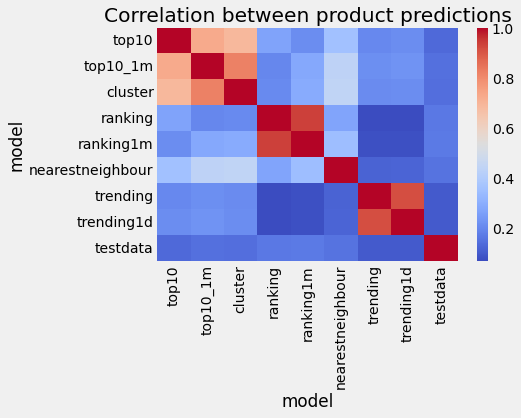

In [472]:
model_titles = ['top10','top10_1m','cluster', 'ranking', 'ranking1m', 'nearestneighbour',
                'trending', 'trending1d','testdata']

sns.heatmap(predict_all.pivot_table(index='cust_stock', 
                                    columns='model', 
                                    values='hit_rate')[model_titles].fillna(0).corr(),
            cmap='coolwarm').set(title='Correlation between product predictions')


Day difference between test invoice and preceeding invoice

In [407]:
inv_gap_list=[]
for i in test_invoices['customerid']:
    if sales_by_invoice[sales_by_invoice['customerid']==i].shape[0]>1:
        inv_gap = sales_by_invoice[sales_by_invoice['customerid']==i] \
            .sort_values(by='invoicedate')['invoicedate'].diff().tail(1).dt.days.values[0]
        inv_gap_list.append([i,inv_gap])

In [408]:
invoice_gaps = pd.DataFrame(inv_gap_list, columns=['customerid','time_gap'])

Aggregate test data to add into prediction dataset for comparison

In [409]:
# 
test_agg = test_data.groupby(['customerid','stockcode_caps'
                             ]).agg(predicted_revenue=('revenue',np.sum)).reset_index()

In [410]:
test_agg['cust_stock'] = test_agg['customerid'] + '/' + test_agg['stockcode_caps']

In [411]:
test_agg['model'] = 'testdata'

In [412]:
test_agg['hit_rate'] = True

In [413]:
predict_all = pd.concat([predict_all,test_agg])

In [414]:
predict_all.drop(columns=['recency_score', 'frequency_score',
       'monetary_score', 'cust_matrix', 'prodsales_deciles'],inplace=True,errors='ignore')

In [415]:
predict_all = predict_all.merge(customer_location[['customerid','recency_score','frequency_score',
                                     'monetary_score', 'cust_matrix']], 
                  on='customerid', 
                  how='left') \
            .merge(stock_descriptions[['stockcode_caps','prodsales_deciles']], 
                   on='stockcode_caps', 
                   how='left')

In [416]:
invoice_gaps

customerid  time_gap
0         13015       143
1         14211         4
2         12463         6
3         16389        18
4         12794        45
...         ...       ...
1708      17581         0
1709      13777         0
1710      15804        10
1711      13113        14
1712      12680        72

[1713 rows x 2 columns]

In [417]:
predict_all = predict_all.merge(invoice_gaps, on='customerid', how='left')

In [418]:
predict_all['time_intervals'] = pd.cut(predict_all['time_gap'], 
                                       bins = [0,7,14,21,28,np.inf], 
                                       labels = ['<7days', '7-13days', '14-20days', 
                                                 '21-27days','>28days'],
                                       right = False)

In [419]:
predict_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342765 entries, 0 to 342764
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   customerid         342765 non-null  object  
 1   stockcode_caps     342765 non-null  object  
 2   model              342765 non-null  object  
 3   hit_rate           342765 non-null  bool    
 4   predicted_revenue  342765 non-null  float64 
 5   cust_stock         342765 non-null  object  
 6   recency_score      342765 non-null  float64 
 7   frequency_score    342765 non-null  float64 
 8   monetary_score     342765 non-null  float64 
 9   cust_matrix        342765 non-null  object  
 10  prodsales_deciles  342765 non-null  int64   
 11  time_gap           253224 non-null  float64 
 12  time_intervals     253224 non-null  category
dtypes: bool(1), category(1), float64(5), int64(1), object(5)
memory usage: 32.0+ MB


In [420]:
predict_all['time_intervals'] = predict_all['time_intervals'].astype('object')

In [421]:
predict_all['time_intervals'] = predict_all['time_intervals'].fillna('no_previous')

In [422]:
predict_all['model'].value_counts()

testdata                   177009
top10                       18560
ranking                     18560
ranking1m                   18560
trending                    18560
trending1d                  18560
trending2_4dec14daynorm     18560
cluster                     18560
top10_1m                    18560
nearestneighbour            17276
Name: model, dtype: int64

In [476]:
model_titles = ['top10','top10_1m','cluster', 'ranking', 'ranking1m', 'nearestneighbour', 
                'trending', 'trending1d','testdata']

In [477]:
# Set float display options


pd.set_option('display.float_format','{:,.2f}'.format)
predict_all.groupby('model').agg(hit_rate=('hit_rate',np.mean),
                                predicted_revenue=('predicted_revenue',np.sum)) \
                                .reindex(index=model_titles)

hit_rate  predicted_revenue
model                                        
top10                 0.09         102,709.34
top10_1m              0.11         120,728.90
cluster               0.11         125,274.45
ranking               0.14         128,063.58
ranking1m             0.15         142,207.14
nearestneighbour      0.14         149,792.06
trending              0.05          47,825.78
trending1d            0.06          49,723.74
testdata              1.00       3,265,507.54

In [455]:
time_interval_titles = ['<7days', '7-13days', '14-20days', '21-27days','>28days','no_previous','All']

In [456]:
# Set float display options
pd.set_option('display.float_format','{:,.3f}'.format)

In [481]:
# Set float display options
pd.set_option('display.float_format','{:,.3f}'.format)

model_titles = ['top10','top10_1m','cluster', 'ranking', 'ranking1m', 'nearestneighbour', 
                'trending', 'trending1d','testdata']

predict_all.pivot_table(index='model', 
                        columns='time_intervals', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:-1,:].reindex(index=model_titles, 
                                                          columns=time_interval_titles)

time_intervals    <7days  7-13days  14-20days  21-27days  >28days  \
model                                                               
top10              0.060     0.082      0.088      0.076    0.073   
top10_1m           0.072     0.093      0.109      0.104    0.084   
cluster            0.069     0.091      0.101      0.093    0.083   
ranking            0.093     0.113      0.125      0.142    0.140   
ranking1m          0.093     0.113      0.125      0.142    0.140   
nearestneighbour   0.091     0.109      0.127      0.143    0.115   
trending           0.028     0.029      0.033      0.039    0.046   
trending1d         0.029     0.033      0.037      0.041    0.048   
testdata           1.000     1.000      1.000      1.000    1.000   

time_intervals    no_previous   All  
model                                
top10                   0.356 0.095  
top10_1m                0.425 0.113  
cluster                 0.425 0.110  
ranking                 0.356 0.142  
ranking1m               0.425 0.148  
nearestneighbour        0.425 0.138  
trending                0.224 0.052  
trending1d              0.243 0.055  
testdata                1.000 1.000

In [483]:
# Set float display options
pd.set_option('display.float_format','{:,.0f}'.format)

model_titles = ['top10','top10_1m','cluster', 'ranking', 'ranking1m', 'nearestneighbour', 
                'trending', 'trending1d','testdata']

time_interval_titles = ['<7days', '7-13days', '14-20days', '21-27days','>28days']

predict_all.pivot_table(index='model', 
                        columns='time_intervals', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins=True).iloc[:-1,:].reindex(index=model_titles, 
                                                          columns=time_interval_titles)

time_intervals    <7days  7-13days  14-20days  21-27days  >28days
model                                                            
top10             14,099    12,049      5,345      3,708   23,061
top10_1m          15,037    12,934      7,037      5,434   21,343
cluster           15,464    13,583      6,477      5,414   25,392
ranking           18,876    12,810      6,794      6,397   38,740
ranking1m         18,780    12,792      6,784      6,397   38,510
nearestneighbour  17,711    18,154      9,428      7,626   37,929
trending           3,754     2,026      1,803      1,611    9,779
trending1d         3,759     2,409      1,870      1,669    9,960
testdata         383,089   273,449    200,262    157,167  862,161

In [463]:
# Set float display options
pd.set_option('display.float_format','{:,.2f}'.format)

predict_all.pivot_table(index='model', 
                        columns='prodsales_deciles', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:-1,:].reindex(index=model_titles)

prodsales_deciles          1    2    3    4  All
model                                           
cluster                 0.11 0.00  NaN  NaN 0.11
nearestneighbour        0.17 0.06 0.05 0.03 0.14
ranking                 0.18 0.10 0.09 0.06 0.14
ranking1m               0.19 0.10 0.09 0.06 0.15
trending                0.06 0.02 0.01 0.01 0.05
trending1d              0.06  NaN  NaN  NaN 0.06
trending2_4dec14daynorm  NaN 0.02 0.02 0.01 0.02
top10                   0.09  NaN  NaN  NaN 0.09
top10_1m                0.11  NaN  NaN  NaN 0.11
testdata                1.00 1.00 1.00 1.00 1.00

In [478]:
# Set float display options
model_titles = ['top10','top10_1m','cluster', 'ranking', 'ranking1m', 'nearestneighbour', 
                'trending', 'trending1d','testdata']

pd.set_option('display.float_format','{:,.0f}'.format)

predict_all.pivot_table(index='model', 
                        columns='prodsales_deciles', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins=True).iloc[:-1,:].reindex(index=model_titles).fillna(0)

prodsales_deciles         1       2       3       4       All
model                                                        
top10               102,709       0       0       0   102,709
top10_1m            120,729       0       0       0   120,729
cluster             125,274       0       0       0   125,274
ranking             110,696  10,521   4,551   2,296   128,064
ranking1m           124,845  10,513   4,553   2,296   142,207
nearestneighbour    143,276   5,093     861     562   149,792
trending             46,912     751     115      48    47,826
trending1d           49,724       0       0       0    49,724
testdata          2,167,185 585,442 316,117 196,764 3,265,508

In [430]:
predict_all.pivot_table(index='cust_matrix', 
                        columns='model', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:,:-1].reindex(columns=model_titles)

model         cluster  nearestneighbour  ranking  ranking1m  trending  \
cust_matrix                                                             
new_cust         0.35              0.35     0.32       0.37      0.14   
problem_cust     0.11              0.13     0.15       0.15      0.08   
star_cust        0.09              0.12     0.12       0.12      0.03   
All              0.11              0.14     0.14       0.15      0.05   

model         trending1d  trending2_4dec14daynorm  top10_1m  testdata  
cust_matrix                                                            
new_cust            0.16                     0.06      0.35      1.00  
problem_cust        0.08                     0.02      0.11      1.00  
star_cust           0.03                     0.01      0.09      1.00  
All                 0.06                     0.02      0.11      1.00

In [431]:
predict_all

customerid stockcode_caps     model  hit_rate  predicted_revenue  \
0           13015          22423     top10      True              25.50   
1           13015         85123A     top10     False               0.00   
2           13015         85099B     top10     False               0.00   
3           13015          47566     top10     False               0.00   
4           13015          84879     top10     False               0.00   
...           ...            ...       ...       ...                ...   
342760     581498         85049E  testdata      True              13.16   
342761     581498         85099B  testdata      True              20.65   
342762     581498         85099C  testdata      True              16.52   
342763     581498          85150  testdata      True               4.96   
342764     581498          85174  testdata      True              10.79   

           cust_stock  recency_score  frequency_score  monetary_score  \
0         13015/22423           2.00             3.00            3.00   
1        13015/85123A           2.00             3.00            3.00   
2        13015/85099B           2.00             3.00            3.00   
3         13015/47566           2.00             3.00            3.00   
4         13015/84879           2.00             3.00            3.00   
...               ...            ...              ...             ...   
342760  581498/85049E           3.00             2.00            3.00   
342761  581498/85099B           3.00             2.00            3.00   
342762  581498/85099C           3.00             2.00            3.00   
342763   581498/85150           3.00             2.00            3.00   
342764   581498/85174           3.00             2.00            3.00   

         cust_matrix  prodsales_deciles  time_gap time_intervals  
0       problem_cust                  1    143.00        >28days  
1       problem_cust                  1    143.00        >28days  
2       problem_cust                  1    143.00        >28days  
3       problem_cust                  1    143.00        >28days  
4       problem_cust                  1    143.00        >28days  
...              ...                ...       ...            ...  
342760      new_cust                  2       NaN    no_previous  
342761      new_cust                  1       NaN    no_previous  
342762      new_cust                  1       NaN    no_previous  
342763      new_cust                  1       NaN    no_previous  
342764      new_cust                  3       NaN    no_previous  

[342765 rows x 13 columns]

In [432]:
predict_all.pivot_table(index='cust_matrix', 
                        columns='model', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins='rows').iloc[:,:-1].reindex(columns=model_titles)

model           cluster  nearestneighbour    ranking  ranking1m  trending  \
cust_matrix                                                                 
new_cust      31,181.68         31,324.98  25,575.45  31,651.88  6,090.98   
problem_cust  45,039.44         49,312.13  43,094.06  51,195.60 32,743.12   
star_cust     49,053.33         69,154.95  59,394.07  59,359.66  8,991.68   
All          125,274.45        149,792.06 128,063.58 142,207.14 47,825.78   

model         trending1d  trending2_4dec14daynorm   top10_1m     testdata  
cust_matrix                                                                
new_cust        7,174.78                 1,008.22  31,181.68   729,089.55  
problem_cust   33,038.10                 3,971.82  45,220.38 1,309,790.18  
star_cust       9,510.86                 4,576.43  44,326.84 1,226,627.81  
All            49,723.74                 9,556.47 120,728.90 3,265,507.54

In [433]:
predict_all.pivot_table(index='recency_score', 
                        columns='model', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:,:-1].reindex(columns=model_titles)

model          cluster  nearestneighbour  ranking  ranking1m  trending  \
recency_score                                                            
2.0               0.11              0.13     0.15       0.15      0.08   
3.0               0.11              0.14     0.14       0.14      0.04   
All               0.11              0.14     0.14       0.15      0.05   

model          trending1d  trending2_4dec14daynorm  top10_1m  testdata  
recency_score                                                           
2.0                  0.08                     0.02      0.11      1.00  
3.0                  0.04                     0.01      0.11      1.00  
All                  0.06                     0.02      0.11      1.00

In [434]:
predict_all.pivot_table(index='recency_score', 
                        columns='model', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins='rows').iloc[:,:-1].reindex(columns=model_titles)

model            cluster  nearestneighbour    ranking  ranking1m  trending  \
recency_score                                                                
2.0            45,039.44         49,312.13  43,094.06  51,195.60 32,743.12   
3.0            80,235.01        100,479.93  84,969.52  91,011.54 15,082.66   
All           125,274.45        149,792.06 128,063.58 142,207.14 47,825.78   

model          trending1d  trending2_4dec14daynorm   top10_1m     testdata  
recency_score                                                               
2.0             33,038.10                 3,971.82  45,220.38 1,309,790.18  
3.0             16,685.64                 5,584.65  75,508.52 1,955,717.36  
All             49,723.74                 9,556.47 120,728.90 3,265,507.54

In [435]:
predict_all.pivot_table(index='frequency_score', 
                        columns='model', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:,:-1].reindex(columns=model_titles)

model            cluster  nearestneighbour  ranking  ranking1m  trending  \
frequency_score                                                            
1.0                 0.11              0.11     0.10       0.11      0.04   
2.0                 0.18              0.21     0.22       0.25      0.10   
3.0                 0.09              0.12     0.12       0.12      0.04   
All                 0.11              0.14     0.14       0.15      0.05   

model            trending1d  trending2_4dec14daynorm  top10_1m  testdata  
frequency_score                                                           
1.0                    0.04                     0.02      0.11      1.00  
2.0                    0.11                     0.03      0.19      1.00  
3.0                    0.04                     0.01      0.09      1.00  
All                    0.06                     0.02      0.11      1.00

In [436]:
predict_all.pivot_table(index='frequency_score', 
                        columns='model', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins='rows').iloc[:,:-1].reindex(columns=model_titles)

model              cluster  nearestneighbour    ranking  ranking1m  trending  \
frequency_score                                                                
1.0               1,440.82          1,440.82   1,351.13   1,440.82    208.07   
2.0              70,151.36         72,256.42  62,337.39  76,737.00 32,662.28   
3.0              53,682.27         76,094.82  64,375.06  64,029.32 14,955.43   
All             125,274.45        149,792.06 128,063.58 142,207.14 47,825.78   

model            trending1d  trending2_4dec14daynorm   top10_1m     testdata  
frequency_score                                                               
1.0                  225.92                   153.85   1,440.82    71,954.13  
2.0               33,700.51                 3,460.37  69,708.95 1,666,838.09  
3.0               15,797.31                 5,942.25  49,579.13 1,526,715.32  
All               49,723.74                 9,556.47 120,728.90 3,265,507.54

In [437]:
predict_all.pivot_table(index='monetary_score', 
                        columns='model', 
                        values='hit_rate', 
                        aggfunc='mean',
                        margins=True).iloc[:,:-1].reindex(columns=model_titles)

model           cluster  nearestneighbour  ranking  ranking1m  trending  \
monetary_score                                                            
2.0                0.07              0.09     0.13       0.13      0.03   
3.0                0.13              0.16     0.15       0.16      0.06   
All                0.11              0.14     0.14       0.15      0.05   

model           trending1d  trending2_4dec14daynorm  top10_1m  testdata  
monetary_score                                                           
2.0                   0.04                     0.01      0.07      1.00  
3.0                   0.07                     0.02      0.14      1.00  
All                   0.06                     0.02      0.11      1.00

In [438]:
predict_all.pivot_table(index='monetary_score', 
                        columns='model', 
                        values='predicted_revenue', 
                        aggfunc='sum',
                        margins='rows').iloc[:,:-1].reindex(columns=model_titles)

model             cluster  nearestneighbour    ranking  ranking1m  trending  \
monetary_score                                                                
2.0             11,287.18         16,585.42  20,667.51  20,877.02  4,071.99   
3.0            113,987.27        133,206.64 107,396.07 121,330.12 43,753.79   
All            125,274.45        149,792.06 128,063.58 142,207.14 47,825.78   

model           trending1d  trending2_4dec14daynorm   top10_1m     testdata  
monetary_score                                                               
2.0               4,296.11                   989.17  10,759.71   471,454.26  
3.0              45,427.63                 8,567.30 109,969.19 2,794,053.29  
All              49,723.74                 9,556.47 120,728.90 3,265,507.54